In [1]:
# make this calculation iterative
# compare with the exact O-U solution
# generalize to 2D
# future work: incorporate Anderson-Mattingly propagator

import sys
sys.path.append("/usr/local/TSG/python")
import TasmanianSG
import numpy as np
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt

In [23]:
grid = TasmanianSG.TasmanianSparseGrid()
iDim = 2
iLevel = 5

In [24]:
grid.makeGlobalGrid(iDim,0,iLevel,"level","gauss-patterson",[])
aPoints = grid.getPoints()
aWeights = grid.getQuadratureWeights()
reordering = np.argsort(aPoints[:,0])
aPoints = aPoints[reordering]
aWeights = aWeights[reordering]
print(aPoints.shape)

(321, 2)


In [25]:
np.dot(aWeights,np.power(aPoints[:,0],4)*np.power(aPoints[:,1],4)) - 2/5*2/5

2.7755575615628914e-17

In [26]:
omega2 = 1
nu = 0.25
sigma = 0.5
def f(x):
    outmat = np.zeros(x.shape)
    outmat[:,0] = x[:,1]
    outmat[:,1] = -omega2*x[:,0] - nu*x[:,1]
    return outmat

def g(x):
    return sigma*np.ones(x.shape)
    

In [27]:
ic = np.array([[1.0,0.0]])
ft = 1.0
numsteps = 20
h = ft/numsteps

# setting things up to integrate from -scaling to +scaling
scaling = 2.0
xgrid = scaling*aPoints
xweights = scaling*scaling*aWeights

np.sum(xweights)

16.0

In [28]:
# define kernel function that takes two vectors as input
# warning: either x or y can be a matrix, but not both at the same time
def G(x, y, h):
    fval = f(y)
    gval = np.abs(g(y))
    mu = y + fval*h
    sd = gval*np.sqrt(h)
    return scipy.stats.norm.pdf(x, loc=mu, scale=sd)

def kernel(x, y, h):
    temp = G(x,y,h)
    return (temp[:,0]*temp[:,1])

#kernel = np.zeros(xweights.shape)
#for i in np.arange(len(xweights)):
#    test = G(xgrid[i,:],ic,h)
#    kernel[i] = test[0]*test[1]

def p(x):
    return kernel(x,ic,h)


In [29]:
# check normalization of initial condition
# remember, you need to evaluate on xgrid to do quadrature,
# but you need to evaluate on collocgrid to do collocation
p1 = p(xgrid)
print(np.dot(xweights,p1))

1.3212128235


In [30]:
endpt = scaling
collocdim = int(np.sqrt(len(aWeights)))
collocgrid = np.mgrid[-endpt:endpt:collocdim*1j, -endpt:endpt:collocdim*1j].reshape(2,-1).T

In [52]:
spacing = np.square(2.0*endpt/(collocdim-1))
def psi(x):
    temp = 1 - np.abs(x)
    if (len(x.shape)==1):
        temp[temp<0] = 0
        return (temp[0]*temp[1])
    else:        
        temp[temp[:,0]<0,0] = 0
        temp[temp[:,1]<0,1] = 0
        return (temp[:,0]*temp[:,1])

def phi(x,j):
    return (psi((x - collocgrid[j,:])/spacing)/spacing)

print(str(spacing) + "\n")
amat = np.zeros((len(collocgrid),len(collocgrid)))
for j in np.arange(len(collocgrid)):
    amat[:,j] = phi(collocgrid,j)

0.0625



In [53]:
bmat = np.zeros((len(collocgrid),len(collocgrid)))
for i in np.arange(len(collocgrid)):
    thisG = kernel(collocgrid[i,:],collocgrid[i,:]+xgrid,h)
    for k in np.arange(len(collocgrid)):
        bmat[i,k] = np.sum(xweights*thisG*phi(collocgrid[i,:]+xgrid,k))


In [56]:
phi(collocgrid[1,:],1)

16.0

In [59]:
# display condition number
print(np.linalg.cond(amat,p=2))
# print(np.linalg.cond(bmat,p=2))

# store psuedoinverse
amatinvbmat = np.linalg.solve(amat,bmat)

np.sum(amatinvbmat,axis=0)

# enforce normalization
# for i in np.arange(len(collocgrid)):
#     amatinvbmat[:,i] = amatinvbmat[:,i]/np.sum(amatinvbmat[:,i])


1.0


array([ -7.96645303,  -9.01480779, -10.06522624, -11.09093549,
       -12.06123789, -12.94485158, -13.71157616, -14.33401662,
       -14.78923057, -15.06016135, -15.13673164, -15.01649981,
       -14.70481868, -14.21448198, -13.56489061, -12.7783439 ,
       -11.78667116,  -9.04963695, -10.18464663, -11.31451556,
       -12.41030932, -13.43851258, -14.36531188, -15.15843769,
       -15.78904066, -16.23345351, -16.47468919, -16.50354314,
       -16.31920031, -15.92929103, -15.34939063, -14.60200864,
       -13.71345868, -12.63189494, -10.03139229, -11.25578951,
       -12.4667394 , -13.6331876 , -14.71870632, -15.68698655,
       -16.50384864, -17.13925213, -17.56914516, -17.77699487,
       -17.75486303, -17.50392932, -17.03441394, -16.36490669,
       -15.52116378, -14.53332531, -13.36507917, -10.98538658,
       -12.29092748, -13.57290443, -14.79876647, -15.92953185,
       -16.92681635, -17.75499591, -18.38332665, -18.78785423,
       -18.95294744, -18.87231899, -18.54944063, -17.99

In [38]:
c1 = np.linalg.solve(amat, p(collocgrid))
# print(np.sum(c1))
# c2 = np.matmul(amatinvbmat,c1).flatten()
# print(np.sum(c2))
# print(np.sum(amatinvbmat,axis=0))

In [39]:
cvec = c1
for i in np.arange(numsteps-1):
    cvec = np.matmul(amatinvbmat,cvec).flatten()

finalpdf = np.matmul(amat,cvec)
exactsol = exactpdf(collocgrid,ft)

In [40]:
print(np.sum(cvec))

1.00000000601


In [41]:
np.linalg.norm(finalpdf - exactsol)/len(xgrid)

0.0022618148350861513

In [42]:
np.dot(xweights, exactpdf(xgrid,ft))

1.0000000019242923

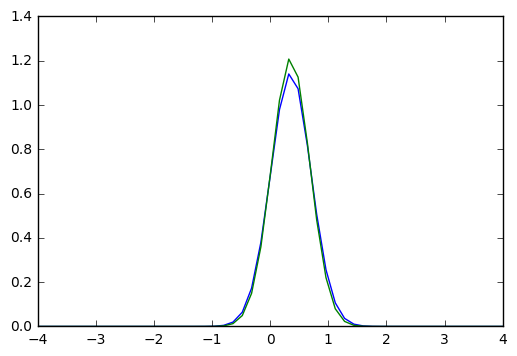

In [43]:
%matplotlib inline
plt.plot(collocgrid, finalpdf)
plt.plot(collocgrid, exactsol)
plt.show()
